In [1]:
import PIL
import matplotlib.pyplot as plt
import cv2 as cv
import time
import numpy as np
from scipy import ndimage as nd

# OpenCV Stereovision

In [ ]:
image_L = cv.imread('/content/drive/MyDrive/TDTecher SDP/Images/left_cone.png', 0)
image_R = cv.imread('/content/drive/MyDrive/TDTecher SDP/Images/right_cone.png', 0)

TypeError: ignored

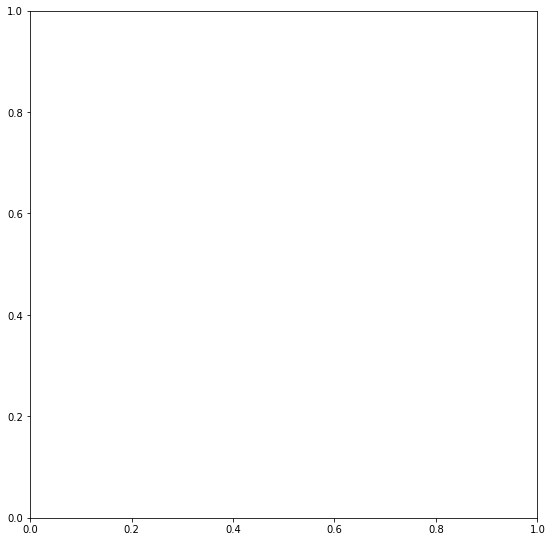

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(image_L)
plt.title('Left Image', fontsize=20)
plt.subplot(122)
plt.imshow(image_R)
plt.title('Right Image', fontsize=20)
plt.tight_layout()

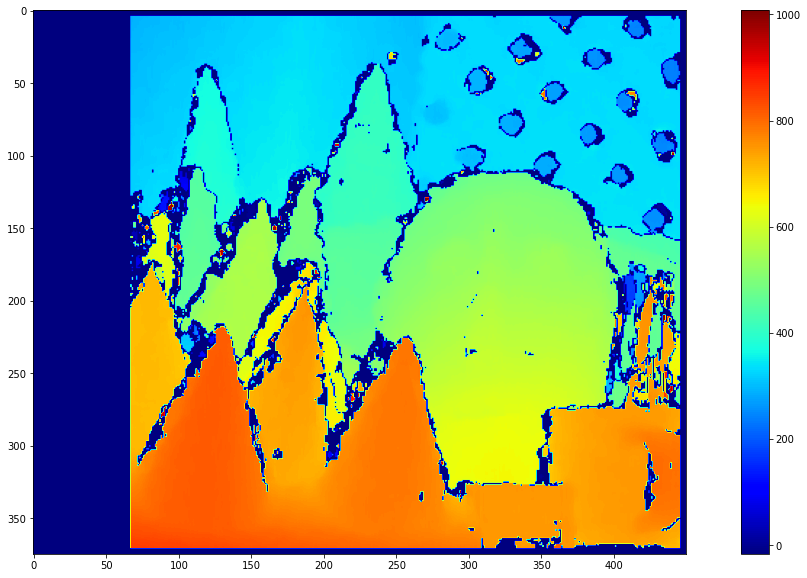

In [ ]:
start = time.time()
stereo = cv.StereoBM_create(numDisparities=64, blockSize=9)
disparity = stereo.compute(image_L, image_R)
end = time.time()

plt.figure(figsize=(20, 10))
plt.imshow(disparity, cmap='jet')
plt.colorbar()

In [ ]:
end -start

0.01896524429321289

# Real-Time Implementation


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import PIL
import matplotlib.pyplot as plt
import cv2 as cv
import time
import numpy as np
from scipy import ndimage as nd

In [4]:
image_L = cv.imread('/content/drive/MyDrive/TDTecher SDP/Images/left_piano.png', 1)
image_L = cv.cvtColor(image_L, cv.COLOR_BGR2RGB)
image_R = cv.imread('/content/drive/MyDrive/TDTecher SDP/Images/right_piano.png', 1)
image_R = cv.cvtColor(image_R, cv.COLOR_BGR2RGB)

image_L_gray = cv.cvtColor(image_L, cv.COLOR_BGR2GRAY) + 1e-1
image_R_gray = cv.cvtColor(image_R, cv.COLOR_BGR2GRAY) + 1e-1

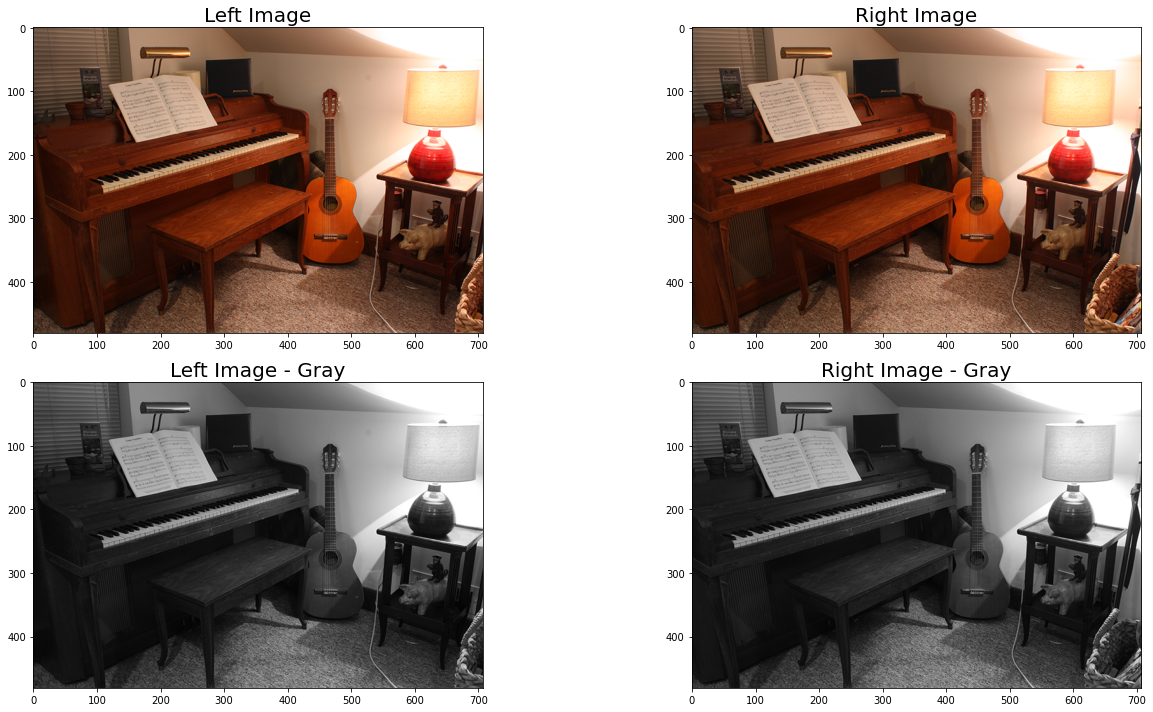

In [5]:
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.imshow(image_L)
plt.title('Left Image', fontsize=20)
plt.subplot(222)
plt.imshow(image_R)
plt.title('Right Image', fontsize=20)
plt.subplot(223)
plt.imshow(image_L_gray, cmap='gray')
plt.title('Left Image - Gray', fontsize=20)
plt.subplot(224)
plt.imshow(image_R_gray, cmap='gray')
plt.title('Right Image - Gray', fontsize=20)
plt.tight_layout()

In [6]:
def cost_block_matching(image_L_gray, image_R_gray, block_x, block_y, disp):

    column_offset = np.floor(block_x/2).astype(int)
    row_offset = np.floor(block_y/2).astype(int)

    col_bound_L = column_offset + disp
    col_bound_U = image_L_gray.shape[1] - column_offset
    row_bound_L = row_offset
    row_bound_U = image_L_gray.shape[0] - row_offset

    cost = np.empty((row_bound_U-row_bound_L, col_bound_U-col_bound_L, disp))

    L_avg = nd.uniform_filter(image_L_gray, (block_y, block_x), mode='constant')
    R_avg = nd.uniform_filter(image_R_gray, (block_y, block_x), mode='constant')

    for d in range(0, disp):
        for r in range(row_bound_L, row_bound_U):
            for c in range(col_bound_L, col_bound_U):

                L_cost = (image_L_gray[r-row_offset:r+row_offset+1, c-column_offset:c+column_offset+1] - L_avg[r, c])
                R_cost = (image_R_gray[r-row_offset:r+row_offset+1, c-column_offset-d:c+column_offset-d+1] - R_avg[r, c-d])

                cost[r-row_bound_L, c-col_bound_L, d] = np.sum(L_cost*R_cost)/np.sqrt((np.sum(L_cost**2)*np.sum(R_cost**2)))

    return cost, row_bound_U-row_bound_L, col_bound_U-col_bound_L

def multiblock(image_L, image_R, block1_x, block1_y, block2_x, block2_y, block3_x, block3_y, disp):

    triblock = np.zeros(np.append(image_L_gray.shape, 3))

    block1, row_size_1, col_size_1 = cost_block_matching(image_L_gray, image_R_gray, block1_x, block1_y, disp)
    block2, row_size_2, col_size_2 = cost_block_matching(image_L_gray, image_R_gray, block2_x, block2_y, disp)
    block3, row_size_3, col_size_3 = cost_block_matching(image_L_gray, image_R_gray, block3_x, block3_y, disp)

    R1 = (image_L_gray.shape[0] - row_size_1 - np.floor(block1_y/2))
    R2 = (image_L_gray.shape[0] - row_size_2 - np.floor(block2_y/2))
    R3 = (image_L_gray.shape[0] - row_size_3 - np.floor(block3_y/2))
    R1 = int(R1)
    R2 = int(R2)
    R3 = int(R3)

    C1 = (image_L_gray.shape[1] - col_size_1 - np.floor(block1_x/2) - 8)
    C2 = (image_L_gray.shape[1] - col_size_2 - np.floor(block2_x/2) - 8)
    C3 = (image_L_gray.shape[1] - col_size_3 - np.floor(block3_x/2) - 8)
    C1 = int(C1)
    C2 = int(C2)
    C3 = int(C3)

    triblock[R1:-R1, C1:-C1, 0] = block1[:, :, 0]
    triblock[R2:-R2, C2:-C2, 1] = block2[:, :, 0]
    triblock[R3:-R3, C3:-C3, 2] = block3[:, :, 0]

    triblock = np.prod(triblock, 2)

    return triblock



In [7]:
mblock = multiblock(image_L_gray, image_R_gray, 9, 9, 21, 3, 3, 21, 16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


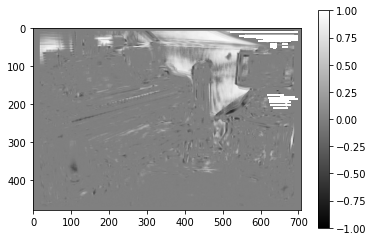

In [8]:
plt.imshow(mblock, cmap='gray')
plt.colorbar()

In [119]:
B, _, _ = cost_block_matching(image_L_gray, image_R_gray, 9, 9, 16)

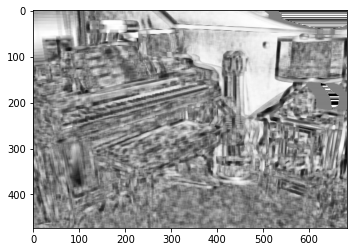

In [125]:
plt.imshow(B[:, :, 0], cmap='gray')

In [132]:
block_x = 9
block_y = 9
disp = 16

column_offset = np.floor(block_x/2).astype(int)
row_offset = np.floor(block_y/2).astype(int)

col_bound_L = column_offset + disp
col_bound_U = image_L_gray.shape[1] - column_offset
row_bound_L = row_offset
row_bound_U = image_L_gray.shape[0] - row_offset
rsize= row_bound_U - row_bound_L

cost = np.empty((row_bound_U-row_bound_L, col_bound_U-col_bound_L, disp))
#cost_vec = cost

L_avg = nd.uniform_filter(image_L_gray, (block_y, block_x), mode='constant')
R_avg = nd.uniform_filter(image_R_gray, (block_y, block_x), mode='constant')

In [133]:
for d in range(0, disp):
    for r in range(row_bound_L, row_bound_U):
        for c in range(col_bound_L, col_bound_U):

            L_cost = (image_L_gray[r-row_offset:r+row_offset+1, c-column_offset:c+column_offset+1] - L_avg[r, c])
            R_cost = (image_R_gray[r-row_offset:r+row_offset+1, c-column_offset-d:c+column_offset-d+1] - R_avg[r, c-d])

            cost[r-row_bound_L, c-col_bound_L, d] = np.sum(L_cost*R_cost)/np.sqrt((np.sum(L_cost**2)*np.sum(R_cost**2)))

In [141]:
r = row_bound_L
c = col_bound_L
(image_L_gray[r-row_offset:r+row_offset+1, c-column_offset:c+column_offset+1] - L_avg[r, c]).sum()

1.4210854715202004e-13

In [152]:
(image_L_gray - L_avg)[]

176.36543209876533

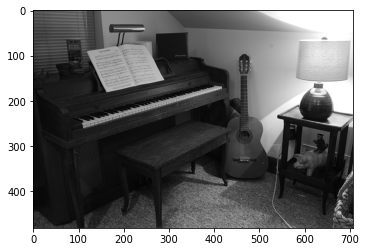

In [163]:
plt.imshow(image_L_gray, cmap='gray')

In [170]:
idx, idx.flatten().reshape(idx.shape)

(array([[  1912,   1913,   1914, ...,   2592,   2593,   2594],
        [  2385,   2386,   2387, ...,   3065,   3066,   3067],
        [  2858,   2859,   2860, ...,   3538,   3539,   3540],
        ...,
        [224222, 224223, 224224, ..., 224902, 224903, 224904],
        [224695, 224696, 224697, ..., 225375, 225376, 225377],
        [225168, 225169, 225170, ..., 225848, 225849, 225850]]),
 array([[  1912,   1913,   1914, ...,   2592,   2593,   2594],
        [  2385,   2386,   2387, ...,   3065,   3066,   3067],
        [  2858,   2859,   2860, ...,   3538,   3539,   3540],
        ...,
        [224222, 224223, 224224, ..., 224902, 224903, 224904],
        [224695, 224696, 224697, ..., 225375, 225376, 225377],
        [225168, 225169, 225170, ..., 225848, 225849, 225850]]))

In [254]:
image_L_gray[row_bound_L+60, col_bound_L+17], image_L_gray.flatten()[(707)*(row_bound_L+60) + col_bound_L+17]

(86.1, 86.1)

In [179]:
image_L_gray, image_L_gray.flatten()

(array([[ 73.1,  73.1,  74.1, ..., 255.1, 255.1, 255.1],
        [ 73.1,  74.1,  73.1, ..., 255.1, 255.1, 255.1],
        [ 77.1,  76.1,  74.1, ..., 255.1, 255.1, 255.1],
        ...,
        [ 46.1,  58.1,  61.1, ...,  66.1,  57.1,  48.1],
        [ 44.1,  43.1,  32.1, ...,  60.1,  57.1,  44.1],
        [ 49.1,  52.1,  30.1, ...,  35.1,  50.1,  49.1]]),
 array([73.1, 73.1, 74.1, ..., 35.1, 50.1, 49.1]))

In [208]:
A = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])
B = np.array([[3, 3, 3, 3], [1, 1, 1, 1], [2, 2, 2, 2], [4, 4, 4, 4]])
A, A.flatten()

(array([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16]]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]))

In [212]:
A.flatten()[4*(3-1) + 3 - 1]

11

In [198]:
image_L_gray[1, 0], image_L_gray.flatten()[rsize-10]

(73.1, 130.1)

In [190]:
np.argwhere(image_L_gray.flatten() == image_L_gray[row_bound_L, col_bound_L])

array([[    18],
       [    19],
       [    23],
       ...,
       [339937],
       [339950],
       [340057]])

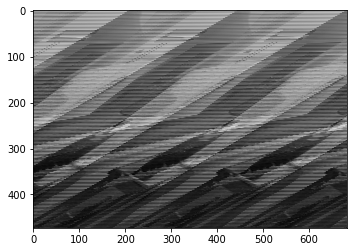

In [161]:
plt.imshow(image_L_gray.flatten()[idx.flatten()].reshape(idx.shape), cmap='gray')

In [153]:
for d in range(0, disp):
  idx = (np.arange(row_bound_L, row_bound_U)*rsize + \
        np.arange(col_bound_L, col_bound_U).reshape(-1, 1)).transpose()
  bead = (np.arange(-row_offset, row_offset+1)*rsize + \
          np.arange(-column_offset, column_offset+1).reshape(-1, 1)).reshape(-1, 1)

  L_string = idx.flatten()
  R_string = (idx - d).flatten()
  L_braid  = L_string + bead
  R_braid  = L_string + bead

  L_cost_str = (image_L_gray - \
                L_avg).flatten()[L_braid.flatten()].reshape(L_braid.shape)
  R_cost_str = (image_R_gray - \
                R_avg).flatten()[R_braid.flatten()].reshape(R_braid.shape)
  LR_cost_str = L_cost_str*R_cost_str

  L_cost = L_cost_str.sum(axis=0).reshape(idx.shape)
  R_cost = R_cost_str.sum(axis=0).reshape(idx.shape)
  L_sqr_cost = (L_cost_str**2).sum(axis=0).reshape(idx.shape)
  R_sqr_cost = (R_cost_str**2).sum(axis=0).reshape(idx.shape)
  LR_cost = LR_cost_str.sum(axis=0).reshape(idx.shape)

  cost_vec[:, :, d] = LR_cost/np.sqrt(L_sqr_cost*R_sqr_cost)

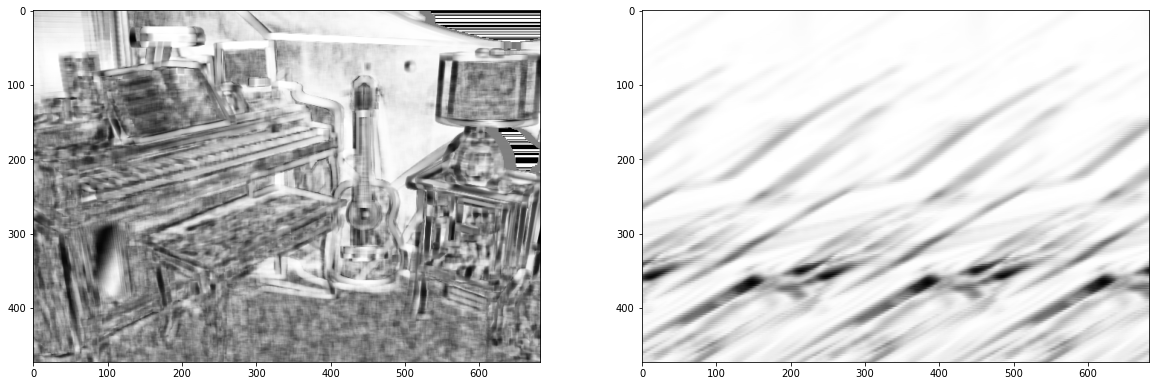

In [154]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(cost[:, :, 15], cmap='gray')
plt.subplot(122)
plt.imshow(cost_vec[:, :, 15], cmap='gray')

In [111]:
rsize = row_bound_U-row_bound_L
d = 10

In [101]:
rsize = row_bound_U-row_bound_L

L_img_idx = (np.arange(row_bound_L, row_bound_U)*rsize + np.arange(col_bound_L, col_bound_U).reshape(-1, 1)).transpose()
L_string = L_img_idx.flatten()
L_bead = np.arange(-row_offset, row_offset+1)*rsize + np.arange(-column_offset, column_offset+1).reshape(-1, 1) 
L_braid = (L_string + L_bead.reshape(-1, 1))
L_cost_string = image_L_gray.flatten()[img_braid.flatten()].reshape(img_braid.shape).sum(axis=0)
L_cost = L_cost_string.reshape(L_img_idx.shape)

In [98]:
L_braid.shape

(81, 323059)

In [95]:
L_string.shape, L_bead.shape

((323059,), (9, 9))

In [92]:
L_img_idx, flat_L_img.reshape(L_img_idx.shape)

(array([[  1912,   1913,   1914, ...,   2592,   2593,   2594],
        [  2385,   2386,   2387, ...,   3065,   3066,   3067],
        [  2858,   2859,   2860, ...,   3538,   3539,   3540],
        ...,
        [224222, 224223, 224224, ..., 224902, 224903, 224904],
        [224695, 224696, 224697, ..., 225375, 225376, 225377],
        [225168, 225169, 225170, ..., 225848, 225849, 225850]]),
 array([[  1912,   1913,   1914, ...,   2592,   2593,   2594],
        [  2385,   2386,   2387, ...,   3065,   3066,   3067],
        [  2858,   2859,   2860, ...,   3538,   3539,   3540],
        ...,
        [224222, 224223, 224224, ..., 224902, 224903, 224904],
        [224695, 224696, 224697, ..., 225375, 225376, 225377],
        [225168, 225169, 225170, ..., 225848, 225849, 225850]]))

In [16]:
image_L_gray[row_bound_L:row_bound_U, col_bound_L:col_bound_U]

(473, 683)

In [50]:
img_string = (np.arange(row_bound_L, row_bound_U)*(row_bound_U-row_bound_L) + np.arange(col_bound_L, col_bound_U).reshape(-1, 1)).flatten()

In [52]:
img_bead = np.arange(-row_offset, row_offset+1)*(row_bound_U-row_bound_L) + np.arange(-column_offset, column_offset+1).reshape(-1, 1) 

In [55]:
img_string, img_bead

(array([  1912,   2385,   2858, ..., 224904, 225377, 225850]),
 array([[-1896, -1423,  -950,  -477,    -4,   469,   942,  1415,  1888],
        [-1895, -1422,  -949,  -476,    -3,   470,   943,  1416,  1889],
        [-1894, -1421,  -948,  -475,    -2,   471,   944,  1417,  1890],
        [-1893, -1420,  -947,  -474,    -1,   472,   945,  1418,  1891],
        [-1892, -1419,  -946,  -473,     0,   473,   946,  1419,  1892],
        [-1891, -1418,  -945,  -472,     1,   474,   947,  1420,  1893],
        [-1890, -1417,  -944,  -471,     2,   475,   948,  1421,  1894],
        [-1889, -1416,  -943,  -470,     3,   476,   949,  1422,  1895],
        [-1888, -1415,  -942,  -469,     4,   477,   950,  1423,  1896]]))

In [73]:
img_braid = (img_string + img_bead.reshape(-1, 1))
img_braid

array([[    16,    489,    962, ..., 223008, 223481, 223954],
       [   489,    962,   1435, ..., 223481, 223954, 224427],
       [   962,   1435,   1908, ..., 223954, 224427, 224900],
       ...,
       [  2862,   3335,   3808, ..., 225854, 226327, 226800],
       [  3335,   3808,   4281, ..., 226327, 226800, 227273],
       [  3808,   4281,   4754, ..., 226800, 227273, 227746]])

In [79]:
image_L_gray.flatten()[img_braid.flatten()].reshape(img_braid.shape).sum(axis=0).shape

(323059,)

In [38]:
y1 = 2
y2 = 3
z1 = 2
z2 = 3

np.arange(0, 16).reshape((4, 4)).flatten()[np.arange(z1-1, z2)*4 + np.arange(y1-1, y2).reshape(-1, 1)]

array([[ 5,  9],
       [ 6, 10]])

array([[ 5,  9],
       [ 6, 10]])

In [25]:
np.arange(0, 16).reshape((4, 4))[2+]

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])